## Introduction
The main purposes of a principal component analysis are the analysis of data to identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.

Here, our desired outcome of the principal component analysis is to project a feature space (our dataset consisting of ***n*** ***d***-dimensional samples) onto a smaller subspace that represents our data “well”. A possible application would be a pattern classification task, where we want to reduce the computational costs and the error of parameter estimation by reducing the number of dimensions of our feature space by extracting a subspace that describes our data “best”.

Adapted from:
http://sebastianraschka.com/Articles/2014_pca_step_by_step.html

### Summarizing the PCA approach

Listed below are the 6 general steps for performing a principal component analysis, which we will investigate in the following sections.

1. Take the whole dataset consisting of dd-dimensional samples ignoring the class labels
2. Compute the dd-dimensional mean vector (i.e., the means for every dimension of the whole dataset)
3. Compute the covariance matrix of the whole data set (or scatter matrix).
4. Compute eigenvectors (***e1,e2,...,ed***) and corresponding eigenvalues (***λ1,λ2,...,λd***)
5. Sort the eigenvectors by decreasing eigenvalues and choose ***k*** eigenvectors with the largest eigenvalues to form a ***d×k*** dimensional matrix ***W***(where every column represents an eigenvector).
6. Use this ***d×k*** eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $y=W^{T} × x$ (where ***x*** is a ***d×1***-dimensional vector representing one sample, and ***y*** is the transformed ***k×1***-dimensional sample in the new subspace.)

### Creating 3D data

In [1]:
# 40 3-dimensional samples randomly drawn from a multivariate Gaussian distribution. 
# Create 3x20 datasets, for 2 classes. Columns can be seen as x = [x1, x2, x3]
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import display

np.random.seed(23423478) # random seed for consistency

mu_vec1 = np.array([0,0,0]) #mean
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]]) #covariance
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class2_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

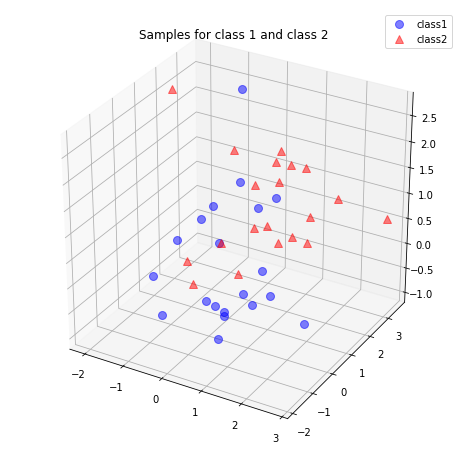

In [3]:
#Show data:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

## 1- Datasets are joined, labels are not considered. 
p.s. (there were no labels here to start with)

In [2]:
all_samples = np.concatenate((class1_sample, class2_sample), axis=1)
assert all_samples.shape == (3,40), "The matrix has not the dimensions 3x40"


## 2 - Mean 

In [3]:
mean_x1 = np.mean(all_samples[0,:])
mean_x2 = np.mean(all_samples[1,:])
mean_x3 = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x1],[mean_x2],[mean_x3]])

print('Mean Vector:\n', mean_vector)

Mean Vector:
 [[ 0.5263457 ]
 [ 0.92743643]
 [ 0.63120536]]


## 3 - Covariance matrix
$$\large{\overline{cov} =  \begin{bmatrix}
cov(X, X) & cov(X,Y) & cov(X,Z)\\ 
cov(Y, X) & cov(Y, Y) & cov(Y, Z)\\ 
cov(Z, X) & cov(Z, Y) & cov(Z, Z) 
\end{bmatrix}}$$

In [4]:
cov_mat = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('Covariance Matrix:\n', cov_mat)

Covariance Matrix:
 [[ 1.10291629  0.12358979  0.04332751]
 [ 0.12358979  1.36606241  0.52491107]
 [ 0.04332751  0.52491107  0.97543698]]


## 4 - Eigenvalues and eigenvectors computed

In [5]:
# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eigh(cov_mat)
print(eig_vec_cov)
# put eigenvctors in single column 
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_cov))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('\n')

[[ 0.07252005 -0.97905362 -0.19024943]
 [-0.57581848  0.11464982 -0.80949891]
 [ 0.81435491  0.16825404 -0.55544276]]
Eigenvector 1: 
[[ 0.07252005]
 [-0.57581848]
 [ 0.81435491]]
Eigenvalue 1 from covariance matrix: 0.60813841806831


Eigenvector 2: 
[[-0.97905362]
 [ 0.11464982]
 [ 0.16825404]]
Eigenvalue 2 from covariance matrix: 1.0809976012721028


Eigenvector 3: 
[[-0.19024943]
 [-0.80949891]
 [-0.55544276]]
Eigenvalue 3 from covariance matrix: 1.75527966934431




## 5 - Sorting Eigenvectors 

The eigenvectors only define the directions of the new axis. In order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop. The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top **k** eigenvectors.


In [6]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i)

(1.75527966934431, array([-0.19024943, -0.80949891, -0.55544276]))
(1.0809976012721028, array([-0.97905362,  0.11464982,  0.16825404]))
(0.60813841806831004, array([ 0.07252005, -0.57581848,  0.81435491]))


### 5b - Determine the percentage of the variance represented by each eigenvalue 

In [7]:
# Calculate the total variance from eigenvalues, the sum of the eigenvalues from covariance.
V_t = np.sum(eig_val_cov)
print("Total variance V_t = %0.4f" % V_t)

# Determine the proportion:
V_prop = [i[0] / V_t for i in eig_pairs]
print("Proportion of variance V_prop = %s" % V_prop.__str__())

# Determine the proportion represented by the first principal component
print("%% of variance represented by the first principal component %0.2f %%" % (V_prop[0] * 100))
# Determine the proportion represented by the first two principal components
print("%% of variance represented by the first two principal components %0.2f %%" % ((V_prop[0]+V_prop[1]) * 100))
pca_var = (V_prop[0]+V_prop[1]) * 100

Total variance V_t = 3.4444
Proportion of variance V_prop = [0.50960157773946768, 0.3138406333542425, 0.17655778890628979]
% of variance represented by the first principal component 50.96 %
% of variance represented by the first two principal components 82.34 %


### 5c - Print out the direction of the eigenvectors

In [8]:
#for v in eig_vec_cov.T:
#    print([mean_x1, v[0]], [mean_x2, v[1]], [mean_x3, v[2]])

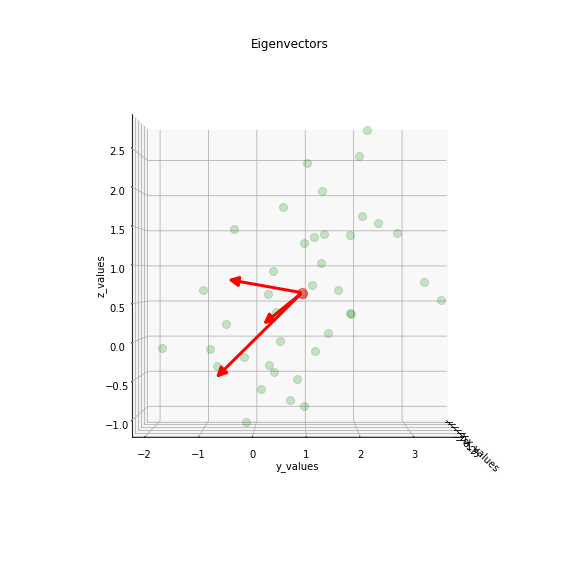

In [9]:
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x1], [mean_x2], [mean_x3], 'o', markersize=10, color='red', alpha=0.5)
ax.view_init(0, 0)
for v in eig_vec_cov.T:
    a = Arrow3D([mean_x1, v[0]], [mean_x2, v[1]], [mean_x3, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

## 6 - Transform original data

We are reducing a 3-dimensional feature space to a 2-dimensional feature subspace, we are combining the two eigenvectors with the highest eigenvalues to construct our ***d×k***-dimensional eigenvector matrix ***W***.

In [10]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n', matrix_w)

Matrix W:
 [[-0.19024943 -0.97905362]
 [-0.80949891  0.11464982]
 [-0.55544276  0.16825404]]


In the last step, we use the ***3×2***-dimensional matrix ***W*** that we just computed to transform our samples onto the new subspace via the equation $y=W^{T} × x$.

In [14]:
transformed = matrix_w.T.dot(all_samples)
assert transformed.shape == (2,40), "The matrix is not 2x40 dimensional."

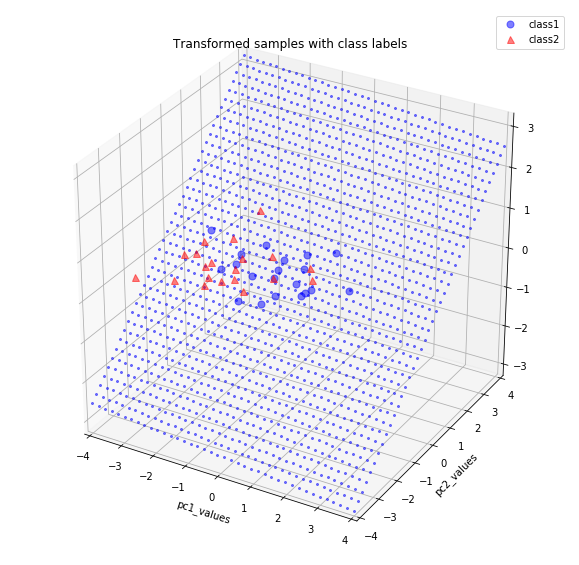

The data in this 2d feature space captures 82.34% of variance in the initial data


In [15]:
#Print figure to show 2d feature space

plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('pc1_values')
plt.ylabel('pc2_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()
print("The data in this 2d feature space captures %0.2f%% of variance in the initial data" % pca_var)

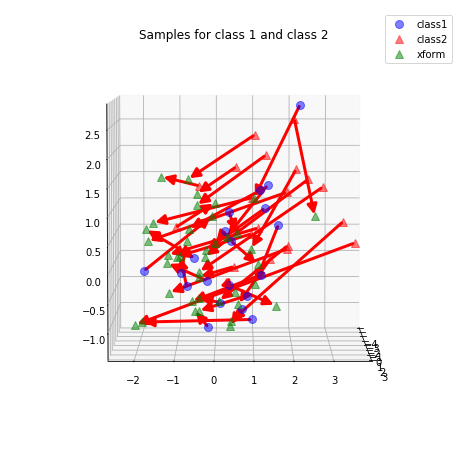

In [16]:
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
   def __init__(self, xs, ys, zs, *args, **kwargs):
       FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
       self._verts3d = xs, ys, zs

   def draw(self, renderer):
       xs3d, ys3d, zs3d = self._verts3d
       xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
       self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
       FancyArrowPatch.draw(self, renderer)


basis = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1), eig_pairs[2][1].reshape(3,1)))
transformed_points = basis.T.dot(all_samples)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10  
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')
ax.plot(transformed_points[0,:], transformed_points[1,:], transformed_points[2,:], '^', markersize=8, alpha=0.5, color='green', label='xform')
ax.view_init(5, 0)

for v, t in zip(all_samples.T, transformed_points.T):
   a = Arrow3D([v[0], t[0]], [v[1], t[1]], [v[2], t[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
   ax.add_artist(a)



plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

## Extra 2 : plotting the plane formed by pc1 and pc2

A plane is defined by the equation:

ax+by+cz=d

The equation is -0.16037519380574916x + 1.4546306205071933y + -2.0323423683417206z = -0.018160758140688404


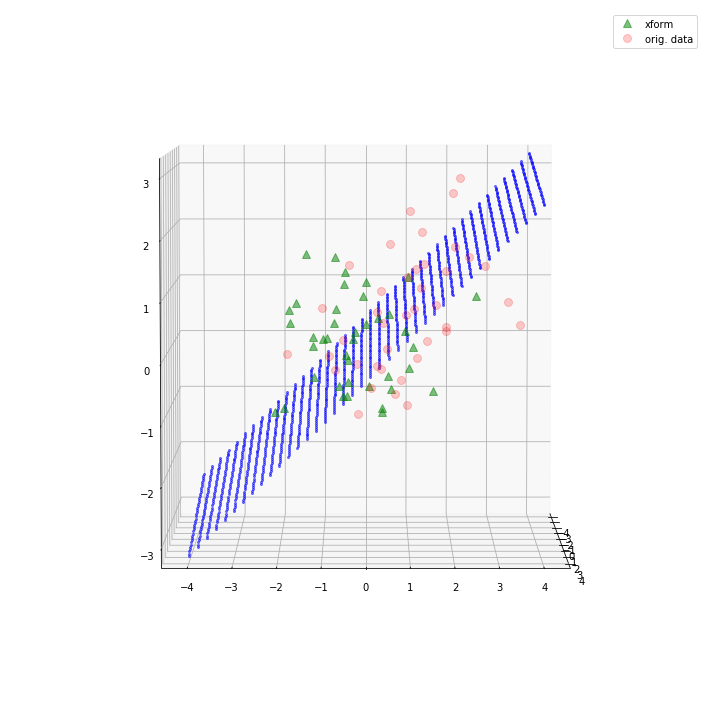

In [17]:
#Define 3 points:
p2 = (matrix_w[:,0].T)
p1 = (mean_vector.T)
p3 = matrix_w[:,1].T

# These two vectors are in the plane
v1 = p2 - p1
v2 = p3 - p1

# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)
a= cp[0][0]
b= cp[0][1]
c= cp[0][2]

# This evaluates a * x3 + b * y3 + c * z3 which equals d
d = np.dot(cp[0], p3)

print('The equation is {0}x + {1}y + {2}z = {3}'.format(a, b, c, d))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-4, 4, 40)
y = np.linspace(-4, 4, 40)
X, Y = np.meshgrid(x, y)

#get z values for the plot
Z = (d - a * X - b * Y) / c

# plot the mesh. Each array is 2D, so we flatten them to 1D arrays
ax.plot(X.flatten(),
        Y.flatten(),
        Z.flatten(), 'bo ', markersize=2, alpha= 0.5)

ax.plot(transformed_points[0,:], transformed_points[1,:], transformed_points[2,:], '^', 
        markersize=8, alpha=0.5, color='green', label='xform')
ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', 
        markersize=8, color='red', alpha=0.2, label = 'orig. data')

# adjust the view so we can see the point/plane alignment
ax.view_init(5, 0)
plt.tight_layout()
ax.legend(loc='upper right')
plt.show()